In [ ]:
!pip install pylatexenc
!pip install qiskit
!pip install qiskit_aer

In [ ]:
# Required imports for Lab 1
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
import numpy as np
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.circuit.library import HGate, CXGate, U3Gate
from tabulate import tabulate
import matplotlib.pyplot as plt

In [ ]:
# Function to create a Bell state between two qubits
def create_bell_state_cont(num_qubits):
    if num_qubits % 2 != 0:
        raise ValueError("Number of qubits must be even to create Bell states on each pair.")

    qc = QuantumCircuit()
    alice = QuantumRegister(num_qubits // 2, 'Alice')
    bob = QuantumRegister(num_qubits // 2, 'Bob')
    qc.add_register(alice)
    qc.add_register(bob)
    for i in range(0, num_qubits, 2):
        qc.h(i)  # Apply Hadamard gate to qubit i
        qc.cx(i, i+1)  # Apply CNOT gate with control=i and target=i+1
    return qc

With this implementation, we can continue and define a function that will add the white noise mixed state and the initial fidelity value to create an initial state based on the number of desired entangled pairs:

In [ ]:
import numpy as np
from qiskit.quantum_info import DensityMatrix

def create_initial_state(num_pairs, prob):
    """
    Create initial product state of num_pairs Bell pairs,
    where each pair has a bit flip (X) applied ONLY on the second qubit (B)
    with probability 'prob'.

    With probability (1 - prob): perfect |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
    With probability prob:       X on B → (|10⟩ + |01⟩)/√2 = |Ψ⁺⟩

    This turns the Bell state into a mixture of |Φ⁺⟩⟨Φ⁺| and |Ψ⁺⟩⟨Ψ⁺|.
    """
    # Perfect Φ⁺ Bell state circuit
    qc_bell = create_bell_state_cont(2)
    bell_dm = DensityMatrix(qc_bell).data  # 4x4 perfect |Φ⁺⟩⟨Φ⁺|

    # Pauli X on qubit B only (I ⊗ X)
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    X_B = np.kron(I, X)

    # Apply X_B to the perfect Bell density matrix
    flipped_dm = X_B @ bell_dm @ X_B.conj().T  # This gives |Ψ⁺⟩⟨Ψ⁺|

    # Mixture: (1-prob) * perfect + prob * flipped
    noisy_pair = prob * bell_dm + (1 - prob) * flipped_dm

    # Tensor product for multiple identical pairs
    final_matrix = noisy_pair
    for _ in range(num_pairs - 1):
        final_matrix = np.kron(final_matrix, noisy_pair)

    return final_matrix  # Full density matrix as numpy array

In [ ]:
prob = 0.7
num_pairs = 4
initial_state_matrix = create_initial_state(num_pairs, prob)

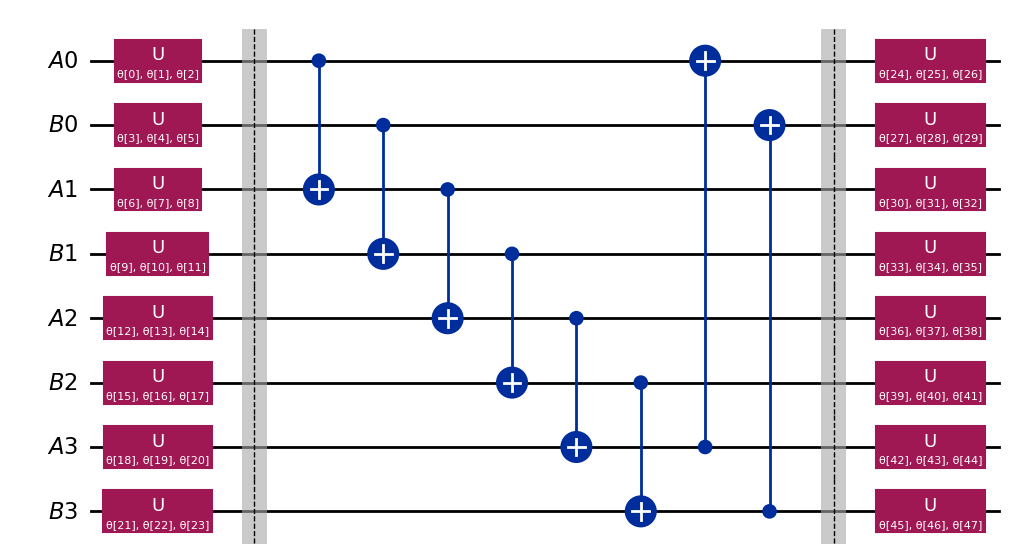

In [ ]:
def qnn_circuit_u3(num_pairs, angles=None):

    num_qubits = num_pairs * 2
    theta_list = ParameterVector('θ', length=num_qubits * 6)  # Adjusted for three parameters per qubit
    qc = QuantumCircuit()

    # Create registers for Alice and Bob
    for i in range(num_pairs):
        alice = QuantumRegister(1, f'A{i}')
        bob = QuantumRegister(1, f'B{i}')
        qc.add_register(alice)
        qc.add_register(bob)

    # Apply initial layer of Rotations
    for i in range(num_qubits):
        qc.u(theta_list[3*i], theta_list[3*i+1], theta_list[3*i+2], i)

    qc.barrier()

    # Apply CNOT gates within Alice's and Bob's registers
    for i in range(num_pairs - 1):
        qc.cx(qc.qubits[2*i], qc.qubits[2*(i+1)])  # CNOT between A[i] and A[i+1]
        qc.cx(qc.qubits[2*i+1], qc.qubits[2*(i+1)+1])  # CNOT between B[i] and B[i+1]

    # Apply the last CNOT for circle entanglement from A[num_pairs-1] to A[0]
    qc.cx(qc.qubits[2*(num_pairs-1)], qc.qubits[0])  # CNOT between A[num_pairs-1] and A[0]
    qc.cx(qc.qubits[2*(num_pairs-1)+1], qc.qubits[1])  # CNOT between B[num_pairs-1] and B[0]

    qc.barrier()

    # Apply second layer of Rotations
    for i in range(num_qubits):
        qc.u(theta_list[num_qubits*3 + 3*i], theta_list[num_qubits*3 + 3*i+1], theta_list[num_qubits*3 + 3*i+2], i)

    return qc

# Initialize parameters array to random values
initial_angles = np.random.uniform(0, np.pi, 48)  # Adjusted for three parameters per qubit for two layers

test_qc = qnn_circuit_u3(4, initial_angles)
test_qc.draw('mpl')

In [ ]:
def classical_nn_forward(outcome_str, weights):
    """
    Feedforward NN with 3 hidden layers
    Input: 6 bits
    Hidden1: 16 shared (ReLU)
    Hidden2: 16 shared (ReLU)
    Hidden3: 18 dedicated (3 per output, ReLU) — NO shared in this layer
    Output: 6 angles in [-π, π]
    """
    x = np.array([int(b) for b in outcome_str]).astype(float)  # (6,)

    offset = 0

    # Layer 1: 6 → 16 shared
    W1 = weights[offset:offset + 6*16].reshape(6, 16)
    offset += 6*16
    b1 = weights[offset:offset + 16]
    offset += 16
    h1 = np.maximum(0, x @ W1 + b1)  # (16,)

    # Layer 2: 16 → 16 shared
    W2 = weights[offset:offset + 16*16].reshape(16, 16)
    offset += 16*16
    b2 = weights[offset:offset + 16]
    offset += 16
    h2 = np.maximum(0, h1 @ W2 + b2)  # (16,)

    # Layer 3: 16 → 18 dedicated (3 per each of 6 outputs)
    dedicated_per_output = 3
    num_dedicated = 6 * dedicated_per_output  # 18
    W3 = weights[offset:offset + 16*num_dedicated].reshape(16, num_dedicated)
    offset += 16*num_dedicated
    b3 = weights[offset:offset + num_dedicated]
    offset += num_dedicated
    h3 = np.maximum(0, h2 @ W3 + b3)  # (18,) — dedicated groups: [0:3] for out0, [3:6] for out1, etc.

    # Output layer: each output connects ONLY to its own 3 dedicated neurons
    # We'll build separate small weight vectors for each output (cleaner, no need to mask a big matrix)
    output = np.zeros(6)
    for i in range(6):
        start = i * dedicated_per_output
        end = start + dedicated_per_output
        h3_i = h3[start:end]  # (3,)

        W_out_i = weights[offset:offset + dedicated_per_output]
        offset += dedicated_per_output
        b_out_i = weights[offset]
        offset += 1

        linear = h3_i @ W_out_i + b_out_i
        output[i] = np.clip(linear, -1, 1) * np.pi

    return output
num_nn_weights = 714

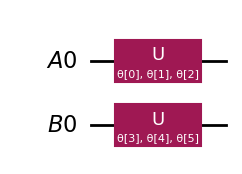

In [ ]:
def qnn_corr_circuit_u3(num_pairs, angles=None):

    num_qubits = num_pairs * 2
    theta_list = ParameterVector('θ', length=num_qubits * 3)  # Adjusted for three parameters per qubit
    qc = QuantumCircuit()

    # Create registers for Alice and Bob
    for i in range(num_pairs):
        alice = QuantumRegister(1, f'A{i}')
        bob = QuantumRegister(1, f'B{i}')
        qc.add_register(alice)
        qc.add_register(bob)

    # Apply initial layer of Rotations
    for i in range(num_qubits):
        qc.u(theta_list[3*i], theta_list[3*i+1], theta_list[3*i+2], i)
    return qc

# Initialize parameters array to random values
initial_angles = np.random.uniform(0, np.pi, 6)  # Adjusted for three parameters per qubit for two layers

test_qc = qnn_corr_circuit_u3(1, initial_angles)
test_qc.draw('mpl')

In [ ]:
from scipy.optimize import minimize

iterations = 0
loss_values = []

# ------------------- Loss Function -------------------
def loss_function(all_params, num_measurements=1000, desired_successful_cases=8):
    """Hybrid loss: QNN + classical NN correction → fidelity with target Bell state."""
    global iterations, loss_values

    qnn_params = all_params[:48]
    nn_weights = all_params[48:]

    loss = 0.0
    counts = 0
    target_state = DensityMatrix(create_bell_state_cont(2))
    # Target: ideal continuous Bell state density matrix
    target_dm = DensityMatrix(create_bell_state_cont(2))
    target_data = target_dm.data

    # Build QNN circuit and evolve initial state
    test_qc = qnn_circuit_u3(4, qnn_params)  # Adjust depth if needed
    test_qc = test_qc.assign_parameters(qnn_params)

    init_matrix = DensityMatrix(initial_state_matrix)
    evolved = init_matrix.evolve(test_qc)

    # Sample measurements and apply corrections
    for _ in range(100):
        outcome, ret_state = evolved.measure([2, 3, 4, 5, 6, 7])  # Measure ancillary qubits?

        rho_ab = partial_trace(ret_state, [2, 3, 4, 5, 6, 7])
        rho_ab = DensityMatrix(rho_ab)
        # Classical NN predicts correction angles

        nn_output = classical_nn_forward(outcome, nn_weights)
        corr_qc = qnn_corr_circuit_u3(1, nn_output)
        corr_qc = corr_qc.assign_parameters(nn_output)
        # Apply predicted local unitaries
        crctd_rho_ab = rho_ab.evolve(corr_qc)

        crctd_rho_ab = crctd_rho_ab.data
        #Fidelity
        loss += 1 - np.real(DensityMatrix(np.matmul(target_state.data, crctd_rho_ab)).trace())
        counts += 1

    iterations += 1
    loss_values.append(loss)

    if iterations % 10 == 0:
        print(f"Iteration {iterations}: Loss = {loss:.4f}")

    return loss

In [ ]:
# ------------------- Optimization Setup -------------------
# Initial parameter guesses
np.random.seed(0)  # For reproducibility (optional but nice)
initial_qnn = np.random.uniform(0, 2 * np.pi, 48)
initial_nn = np.random.uniform(-0.1, 0.1, num_nn_weights)

initial_all = np.concatenate([initial_qnn, initial_nn])

print("Starting optimization... This might take a while! ☕")

# Run optimization (COBYLA is great for noisy/derivative-free problems)
result = minimize(
    loss_function,
    initial_all,
    method='COBYLA',
    tol=1e-1,
    options={'maxiter': 2000, 'disp': True}
)

# Extract optimized parameters
opt_qnn = result.x[:48]
opt_nn = result.x[48:]

print("\nOptimization finished! 🎉")
print(f"Minimum loss achieved: {result.fun:.6f}")
print(f"Optimized QNN parameters shape: {opt_qnn.shape}")
print(f"Optimized NN weights shape: {opt_nn.shape}")

Starting optimization... This might take a while! ☕
Iteration 10: Loss = 76.3167
Iteration 20: Loss = 75.9097
Iteration 30: Loss = 73.2161
Iteration 40: Loss = 75.2418
Iteration 50: Loss = 75.0374
Iteration 60: Loss = 75.3007
Iteration 70: Loss = 74.7378
Iteration 80: Loss = 75.1917
Iteration 90: Loss = 76.0848
Iteration 100: Loss = 73.9075
Iteration 110: Loss = 75.2835
Iteration 120: Loss = 75.6030
Iteration 130: Loss = 75.7223
Iteration 140: Loss = 75.2064
Iteration 150: Loss = 76.5586
Iteration 160: Loss = 74.9284
Iteration 170: Loss = 74.1621
Iteration 180: Loss = 74.6831
Iteration 190: Loss = 74.8220
Iteration 200: Loss = 73.3582
Iteration 210: Loss = 75.1072
Iteration 220: Loss = 77.0232
Iteration 230: Loss = 74.5469
Iteration 240: Loss = 74.6551
Iteration 250: Loss = 75.1800
Iteration 260: Loss = 75.0853
Iteration 270: Loss = 75.5246
Iteration 280: Loss = 74.0967
Iteration 290: Loss = 74.4451
Iteration 300: Loss = 76.1066
Iteration 310: Loss = 75.2048
Iteration 320: Loss = 74.14

In [ ]:
# Calculate input state fidelity
fidelity_in = (3 * prob + 1) / 4
# Calculate output state fidelity
cases = 100
fidelity = (cases - result.fun) / cases

print("The fidelity of the input quantum state is：%.5f" % fidelity_in)
print("The fidelity of the purified quantum state is： %.5f" % fidelity)

In [ ]:
# Plot iteration vs loss
plt.plot(range(1, iterations + 1), loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Iteration vs Loss Function')
plt.show()